TODO: integrate the mean of the posterior numerically

## Setup 

activate fisher_info_limits

In [327]:
# import packages
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle5 as pickle
from scipy.stats import spearmanr, wilcoxon
from matplotlib.gridspec import GridSpec as GS
import math
from scipy.stats import poisson
from scipy.optimize import minimize_scalar
from tqdm import tqdm
from scipy.special import radian as rad
from scipy.stats import circstd

main_dir = '/Users/steeve_laquitaine/Desktop/CARLO/code/fisher-info-limits/'
os.chdir(main_dir)

# import custom package
import ssiProjectModule as ssiMod

# setup parameters
N_TRIALS = 10000 #int(10000) # 8 min
sample_size = 500
theta_step = 2
stim = np.arange(0,360,theta_step)

# setup paths
main_dir = '/Users/steeve_laquitaine/Desktop/CARLO/code/fisher-info-limits/'
dat_dir_in = main_dir + 'data/decoding_analysis/'
data_dir = 'data/bayer_decoding_error/'+f'Bayes_Dec_Errs_{sample_size}reps_thetastep{theta_step}'+'.npz'

title = f'Stretch_BioQuads_multiplied_w_mean_g__theta_step={theta_step}_original_g_20240509_AREA.pkl'

constant = 360/np.sqrt(2*np.pi*math.e)

with open(dat_dir_in+title, 'rb') as rick:
    data_dict = pickle.load(rick)

bio_idx = np.where(data_dict['all_multipliers']==1.)[0][0]

# four columns for four types of retina cardinal tuning curves distribution
chosen_quads = np.array([201, 125, 104, 491])

## Custom functions

In [328]:
# Bayesian (maximum likelihood) decoder

def generate_responses(tuning_curves, true_direction_index, n_trials=10, seed=0):
    """
    Generate Poisson spike counts for all neurons given a true direction.
    
    Parameters:
    - true_direction_index: true motion direction index 
    - n_trials: number of trials to simulate
    
    Returns:
    - responses: array of spike counts [n_trials, n_neurons]
    """
    # setup reproducibility
    np.random.seed(seed)

    # parameters
    n_neurons = tuning_curves.shape[1]
    responses = np.zeros((n_trials, n_neurons))
    
    for n_i in range(n_neurons):
        mean_firing_rate = tuning_curves[true_direction_index, n_i]
        responses[:, n_i] = poisson.rvs(mean_firing_rate, size=n_trials)
    return responses


def log_likelihood(direction_index, responses, tuning_curves):
    """Compute log likelihood of observed responses given a direction.
    
    Parameters:
    - direction (float): candidate direction (degrees)
    - responses: observed spike counts for all neurons
    
    Returns:
    - log_likelihood: log probability of the data
    """
    n_neurons = tuning_curves.shape[1]
    direction_index = int(direction_index) # make an integer 

    log_prob = 0
    
    # Poisson log likelihood ( sum(r * ln(mean_r) - mean_r) )
    for n_i in range(n_neurons):
        mean_firing_rate = tuning_curves[direction_index, n_i]
        log_prob += responses[n_i] * np.log(mean_firing_rate + 1e-10) - mean_firing_rate
    return log_prob


def decode_direction(observed_responses, tuning_curves, bounds=(0,180)):
    """decode direction using maximum likelihood estimation (flat prior).
    
    Parameters:
    - observed_responses: observed spike counts for all neurons
    
    Returns:
    - decoded direction index: estimated direction index (integer)
    """
    # define negative log likelihood function for optimization
    def neg_log_likelihood(direction_index):
        return - log_likelihood(direction_index, observed_responses, tuning_curves)
    
    # search over full range of directions
    result = minimize_scalar(neg_log_likelihood, bounds=bounds, method='bounded')
    return int(result.x)


def compute_bayesian_decoding_error(true_directions, tuning_c, n_trials=100, seed=0):

    all_true_dirs = []
    all_decoded_dirs = []
    all_errors_deg = []
    all_errors_rad = []

    # loop over stimulus in stimulus space
    for dir_ix, true_dir in tqdm(enumerate(true_directions), total=len(true_directions)):

        # (n trials, 4 neurons) responses
        responses = generate_responses(tuning_c.T, int(dir_ix), n_trials=n_trials, seed=seed)

        # loop over many trials
        for trial in range(n_trials):
            
            # decode each trial
            decoded_dir_ix = decode_direction(responses[trial,:], 
                                              tuning_c.T, 
                                              bounds=(0, len(true_directions)-1))
            decoded_dir = true_directions[decoded_dir_ix]

            # compute circular error
            error_deg = min(abs(decoded_dir - true_dir), 360 - abs(decoded_dir - true_dir))       
            error_rad = rad(error_deg, 0, 0)

            # record direction x trials
            all_true_dirs.append(true_dir)
            all_decoded_dirs.append(decoded_dir)
            all_errors_deg.append(error_deg)         
            all_errors_rad.append(error_rad)      

    all_true_dirs = np.array(all_true_dirs)
    all_decoded_dirs = np.array(all_decoded_dirs)
    all_errors_deg = np.array(all_errors_deg)
    all_errors_rad = np.array(all_errors_rad)

    # calculate estimate errors as std
    stds_deg = []
    stds_circ = []
    
    for _, true_dir in enumerate(true_directions):

        this_true_dir_pos = all_true_dirs== true_dir
        
        # method 1: std over degrees
        std_deg = np.sqrt((all_errors_deg[this_true_dir_pos]**2).mean())
        
        # method 2: circular std over radians
        std_circ = circstd(all_errors_rad[this_true_dir_pos])
        
        # record
        stds_deg.append(std_deg)
        stds_circ.append(std_circ)

    stds_deg = np.array(stds_deg)
    stds_circ = np.array(stds_circ)

    return {
        'true_directions': all_true_dirs,
        'decoded_directions': all_decoded_dirs,
        'errors_deg': all_errors_deg,
        'errors_rad': all_errors_rad,
        'stds_deg': stds_deg,
        'stds_circ': stds_circ
    }

## Load datasets

- Bayes error: std of Bayesian decoder estimates (assuming flat prior)
- Fisher error: std of unbiased decoder estimates: $\sigma = \frac{1}{\sqrt(J_0)}$ (see Brunel & Nadal 1998)

In [329]:
# load bayesian decoding errors
bayes_dec_err = dict(np.load(data_dir))['bayes_final_angles_errs']

# load fisher information metrics
fisher_info = np.array([ssiMod.FISHER_POISSON(stim, quad_tc) for quad_tc in data_dict['all_quad_tc'][:,bio_idx]])

# load ssi metrics
ssis = data_dict['all_ssis'][:,bio_idx]

## Study

### Basic code

In [330]:
%%time

# code ------------------------------------------------------------------

# setup parameters
N_NEURONS = 4
AMPLITUDE = 4000
WIDTH = 0.5
BASELINE = 0

# setup the preferred angle of each neuron
preferred_angles = np.linspace(0, 360, N_NEURONS, endpoint=False)

# create tuning curves
tuning_c = []
for ix, pref_angle in enumerate(preferred_angles):
    tuning_c.append(ssiMod.VON_MISES(th=stim, a=AMPLITUDE, th_0=pref_angle, s=WIDTH, baseline=BASELINE))
tuning_c = np.array(tuning_c)

# describe
print('Preferred angles:', preferred_angles)
print("tuning curve shape:", tuning_c.shape)

# Bayesian error (8 min for 10k trials) ----------------------------------

bayes_out = compute_bayesian_decoding_error(stim, tuning_c, n_trials=N_TRIALS, seed=0)

Preferred angles: [  0.  90. 180. 270.]
tuning curve shape: (4, 180)


100%|██████████| 180/180 [07:54<00:00,  2.63s/it]


CPU times: user 7min 52s, sys: 1.97 s, total: 7min 53s
Wall time: 7min 54s


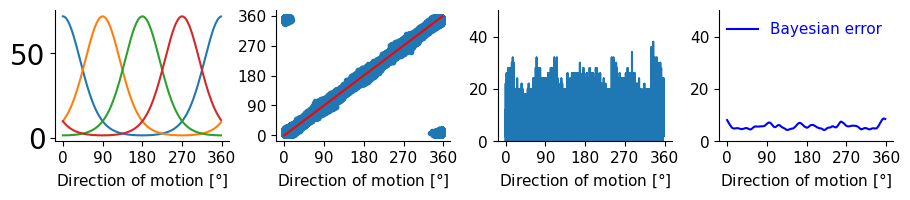

In [331]:
# plot 
fig, ax = plt.subplots(1,4, figsize=(9,1.8))

# tuning curves
ax[0].plot(stim, tuning_c.T);
ax[0].set_xticks(np.arange(0,361,90))
ax[0].tick_params(axis="x", labelsize=11)
ax[0].set_xlabel(r'Direction of motion [$\degree$]', size = 11)

# estimates
ax[1].plot(bayes_out['true_directions'], bayes_out['decoded_directions'],'.')
ax[1].plot(stim, stim, color='r', linestyle='-')
ax[1].set_xticks(np.arange(0,361,90))
ax[1].set_yticks(np.arange(0,361,90))
ax[1].tick_params(axis="x", labelsize=11)
ax[1].tick_params(axis="y", labelsize=11)
ax[1].set_xlabel(r'Direction of motion [$\degree$]', size = 11)

# errors
ax[2].plot(bayes_out['true_directions'], bayes_out['errors_deg'])
ax[2].set_xticks(np.arange(0,361,90))
ax[2].set_ylim([0, 50])
ax[2].tick_params(axis="x", labelsize=11)
ax[2].tick_params(axis="y", labelsize=11)
ax[2].set_xlabel(r'Direction of motion [$\degree$]', size = 11)

# bayesian error (std)
ax[3].plot(stim, bayes_out['stds_deg'], color = 'blue', label='Bayesian error')
ax[3].set_xticks(np.arange(0,361,90))
ax[3].tick_params(axis="x", labelsize=11)
ax[3].tick_params(axis="y", labelsize=11)
ax[3].set_ylim([0, 50])
ax[3].set_xlabel(r'Direction of motion [$\degree$]', size = 11)
ax[3].legend(labelcolor = 'linecolor', frameon=0, fontsize = 11, loc=(0.01, 0.75))

plt.tight_layout(pad=0)

### Retina code 1

In [332]:
%%time

ix = 0; 
quad = chosen_quads[ix] # get one of four tuning types
tuning_c = data_dict['all_quad_tc'][quad,bio_idx] # tuning curves (4 x 180)
bayes_out = compute_bayesian_decoding_error(stim, tuning_c, n_trials=N_TRIALS, seed=0) # bayesian error (8 min-10k trials)

100%|██████████| 180/180 [08:16<00:00,  2.76s/it]


CPU times: user 8min 15s, sys: 1.51 s, total: 8min 16s
Wall time: 8min 17s


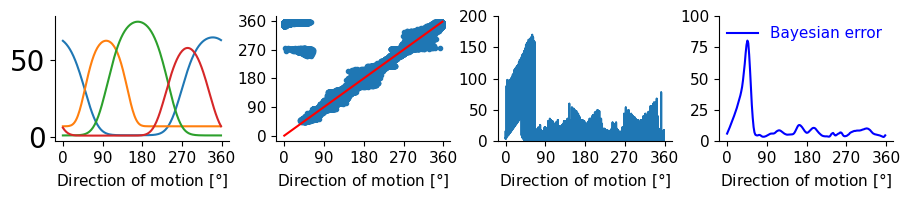

In [333]:
# plot 
fig, ax = plt.subplots(1,4, figsize=(9,1.8))

# tuning curves
ax[0].plot(stim, tuning_c.T);
ax[0].set_xticks(np.arange(0,361,90))
ax[0].tick_params(axis="x", labelsize=11)
ax[0].set_xlabel(r'Direction of motion [$\degree$]', size = 11)

# estimates
ax[1].plot(bayes_out['true_directions'], bayes_out['decoded_directions'],'.')
ax[1].plot(stim, stim, color='r', linestyle='-')
ax[1].set_xticks(np.arange(0,361,90))
ax[1].set_yticks(np.arange(0,361,90))
ax[1].tick_params(axis="x", labelsize=11)
ax[1].tick_params(axis="y", labelsize=11)
ax[1].set_xlabel(r'Direction of motion [$\degree$]', size = 11)

# errors
ax[2].plot(bayes_out['true_directions'], bayes_out['errors_deg'])
ax[2].set_xticks(np.arange(0,361,90))
ax[2].set_ylim([0, 200])
ax[2].tick_params(axis="x", labelsize=11)
ax[2].tick_params(axis="y", labelsize=11)
ax[2].set_xlabel(r'Direction of motion [$\degree$]', size = 11)

# bayesian error (std)
ax[3].plot(stim, bayes_out['stds_deg'], color = 'blue', label='Bayesian error')
ax[3].set_xticks(np.arange(0,361,90))
ax[3].tick_params(axis="x", labelsize=11)
ax[3].tick_params(axis="y", labelsize=11)
ax[3].set_ylim([0, 100])
ax[3].set_xlabel(r'Direction of motion [$\degree$]', size = 11)
ax[3].legend(labelcolor = 'linecolor', frameon=0, fontsize = 11, loc=(0.01, 0.75))

plt.tight_layout(pad=0)

### Retina code 2

In [334]:
%%time

ix = 1;  # get one of four tuning types
quad = chosen_quads[ix] 
tuning_c = data_dict['all_quad_tc'][quad, bio_idx] # get tuning curves (4 x 180)
bayes_out = compute_bayesian_decoding_error(stim, tuning_c, n_trials=N_TRIALS, seed=0) # bayesian error

  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [08:04<00:00,  2.69s/it]


CPU times: user 8min 3s, sys: 744 ms, total: 8min 4s
Wall time: 8min 5s


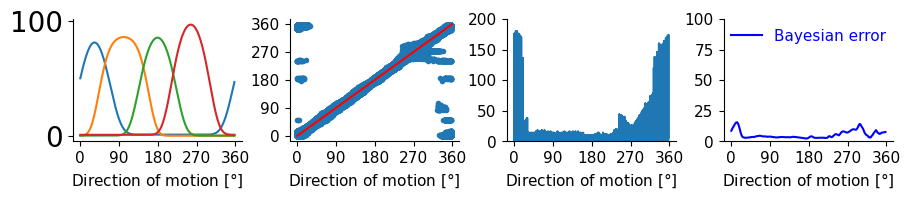

In [335]:
# plot 
fig, ax = plt.subplots(1,4, figsize=(9,1.8))

# tuning curves
ax[0].plot(stim, tuning_c.T);
ax[0].set_xticks(np.arange(0,361,90))
ax[0].tick_params(axis="x", labelsize=11)
ax[0].set_xlabel(r'Direction of motion [$\degree$]', size = 11)

# estimates
ax[1].plot(bayes_out['true_directions'], bayes_out['decoded_directions'],'.')
ax[1].plot(stim, stim, color='r', linestyle='-')
ax[1].set_xticks(np.arange(0,361,90))
ax[1].set_yticks(np.arange(0,361,90))
ax[1].tick_params(axis="x", labelsize=11)
ax[1].tick_params(axis="y", labelsize=11)
ax[1].set_xlabel(r'Direction of motion [$\degree$]', size = 11)

# errors
ax[2].plot(bayes_out['true_directions'], bayes_out['errors_deg'])
ax[2].set_xticks(np.arange(0,361,90))
ax[2].set_ylim([0, 200])
ax[2].tick_params(axis="x", labelsize=11)
ax[2].tick_params(axis="y", labelsize=11)
ax[2].set_xlabel(r'Direction of motion [$\degree$]', size = 11)

# bayesian error (std)
ax[3].plot(stim, bayes_out['stds_deg'], color = 'blue', label='Bayesian error')
ax[3].set_xticks(np.arange(0,361,90))
ax[3].tick_params(axis="x", labelsize=11)
ax[3].tick_params(axis="y", labelsize=11)
ax[3].set_ylim([0, 100])
ax[3].set_xlabel(r'Direction of motion [$\degree$]', size = 11)
ax[3].legend(labelcolor = 'linecolor', frameon=0, fontsize = 11, loc=(0.01, 0.75))

plt.tight_layout(pad=0)

### Retina code 3

In [336]:
%%time

ix = 2;  # get one of four tuning types
quad = chosen_quads[ix] 
tuning_c = data_dict['all_quad_tc'][quad, bio_idx] # get tuning curves (4 x 180)
bayes_out = compute_bayesian_decoding_error(stim, tuning_c, n_trials=N_TRIALS, seed=0) # bayesian error

100%|██████████| 180/180 [08:44<00:00,  2.91s/it]


CPU times: user 8min 43s, sys: 674 ms, total: 8min 44s
Wall time: 8min 45s


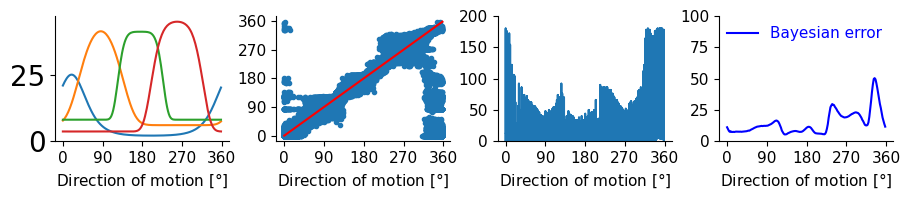

In [337]:
# plot 
fig, ax = plt.subplots(1,4, figsize=(9,1.8))

# tuning curves
ax[0].plot(stim, tuning_c.T);
ax[0].set_xticks(np.arange(0,361,90))
ax[0].tick_params(axis="x", labelsize=11)
ax[0].set_xlabel(r'Direction of motion [$\degree$]', size = 11)

# estimates
ax[1].plot(bayes_out['true_directions'], bayes_out['decoded_directions'],'.')
ax[1].plot(stim, stim, color='r', linestyle='-')
ax[1].set_xticks(np.arange(0,361,90))
ax[1].set_yticks(np.arange(0,361,90))
ax[1].tick_params(axis="x", labelsize=11)
ax[1].tick_params(axis="y", labelsize=11)
ax[1].set_xlabel(r'Direction of motion [$\degree$]', size = 11)

# errors
ax[2].plot(bayes_out['true_directions'], bayes_out['errors_deg'])
ax[2].set_xticks(np.arange(0,361,90))
ax[2].set_ylim([0, 200])
ax[2].tick_params(axis="x", labelsize=11)
ax[2].tick_params(axis="y", labelsize=11)
ax[2].set_xlabel(r'Direction of motion [$\degree$]', size = 11)

# bayesian error (std)
ax[3].plot(stim, bayes_out['stds_deg'], color = 'blue', label='Bayesian error')
ax[3].set_xticks(np.arange(0,361,90))
ax[3].tick_params(axis="x", labelsize=11)
ax[3].tick_params(axis="y", labelsize=11)
ax[3].set_ylim([0, 100])
ax[3].set_xlabel(r'Direction of motion [$\degree$]', size = 11)
ax[3].legend(labelcolor = 'linecolor', frameon=0, fontsize = 11, loc=(0.01, 0.75))

plt.tight_layout(pad=0)

### Original figure

In [338]:
labelsize = 25
legend_fontsize = 15
text_size = 30
tick_labelsize = 20

plt.rcParams['xtick.labelsize']=tick_labelsize
plt.rcParams['ytick.labelsize']=tick_labelsize
mpl.rcParams['axes.spines.right']=False
fig = plt.figure(figsize=(25,15))

gs = GS(5,4,wspace=0.3, hspace=0.75)
colors = ['blue', 'green', 'red', 'gold']
letters = ['A)', 'B)', 'C)', 'D)']
for i, quad in enumerate(chosen_quads):
    print(quad)
    
#     TUNING CURVE ROW
    ax = fig.add_subplot(gs[0,i])
    for j, tc in enumerate(data_dict['all_quad_tc'][quad, bio_idx]):
        ax.plot(stim, tc/1.6, color = colors[j])
    ax.text(-70, 85, letters[i], size=text_size)
    ax.set_xlim(0,360)
    ax.set_ylim(0,75)    
    ax.set_xticks(np.arange(0,361, 90))
    ax.set_yticks(np.arange(0,76, 25))
#     if i==0:
#         ax.set_xlabel(r'Direction of motion [$\degree$]')
        

#     SSI ROW
        
    ax1 = fig.add_subplot(gs[1,i])
    ax2 = ax1.twinx()
    
    ax1.plot(stim, ssis[quad], color = 'magenta')
    ax2.plot(stim, fisher_info[quad], color = 'orange')
    ax2.spines['right'].set_visible(True)
    ax1.tick_params('y', labelcolor = 'magenta')
    ax2.tick_params('y', labelcolor = 'orange')
    
    ax1.set_xlim(0,360)
    ax1.set_ylim(0,6)  
    ax2.set_ylim(0,0.15)
    ax1.set_xticks(np.arange(0,361, 90))
    ax1.set_yticks(np.arange(0,6.1, 2))
    ax2.set_yticks(np.arange(0,0.151, 0.05))   
    
    ax3 = fig.add_subplot(gs[2,i])
    ax3.plot(stim, constant*math.e**(-ssis[quad]*np.log(2)), \
            color = 'magenta', label = r'Sensitivity error')
    ax3.plot(stim, bayes_dec_err[quad], color = 'blue', label = 'Bayesian error')
    ax3.plot(stim, 1/np.sqrt(fisher_info[quad]), color = 'orange', label = r'Fisher error')
    if i==0:
        ax3.legend(handlelength = 0, labelcolor = 'linecolor', frameon=0, \
                   loc = (0.01, 0.45), fontsize = legend_fontsize)
    
    ax3.set_xlim(0,360)
    ax3.set_ylim(0,50)    
    ax3.set_xticks(np.arange(0,361, 90))
    ax3.set_xlabel(r'Direction of motion [$\degree$]', size = labelsize)
    
    if i==0:
        ax.yaxis.set_label_coords(-0.135, y=0.5)
        ax1.yaxis.set_label_coords(-0.135, y=0.5)
        ax3.yaxis.set_label_coords(-0.135, y=0.5)
        
        ax.set_ylabel('Tuning\n'+r'curve [$Hz$]', size = labelsize)  
        ax1.set_ylabel('Sensitivity\n'+r'[$Bits$]', color = 'magenta', size = labelsize)
        ax3.set_ylabel('Decoding\n'+r'Error [$\degree$]', size = labelsize)  
    if i==len(chosen_quads)-1:
        ax2.yaxis.set_label_coords(1.35, y=0.5)
        ax2.set_ylabel('Fisher\n'+r'Information', rotation=270, color = 'orange', size = labelsize)
        
ax4 = fig.add_subplot(gs[3:5,:2])

spearman_ssi_v_bayes = np.array([spearmanr(-data_dict['all_ssis'][idx, bio_idx], el).correlation \
                                           for idx, el in enumerate(bayes_dec_err)])
spearman_fisher_v_bayes = np.array([spearmanr(1/np.sqrt(fisher_info[idx]), el).correlation \
                                           for idx, el in enumerate(bayes_dec_err)])

ax4.hist(spearman_ssi_v_bayes, range=(-1,1), bins = 30, color = 'magenta', histtype = 'step')
ax4.plot([0],[0], color = 'magenta', label = r'Bayesian vs Sensitivity')

ax4.hist(spearman_fisher_v_bayes, range=(-1,1), bins = 30, color = 'orange', histtype = 'step')
ax4.plot([0],[0], color = 'orange',label = r'Bayesian vs Fisher')
ax4.yaxis.set_label_coords(-0.075, y=0.5)


ax4.axvline(np.median(spearman_ssi_v_bayes), color = 'magenta', linestyle='dashed')
ax4.axvline(np.median(spearman_fisher_v_bayes), color = 'orange', linestyle='dashed')
#     ax4.text(-0.9, 75, f'p-value<<{0.00001:.0e}', size = 12)
ax4.set_xticks(np.arange(-1,1.1,0.25))
ax4.set_yticks(np.arange(0,151,25))
print(wilcoxon(spearman_ssi_v_bayes-spearman_fisher_v_bayes))
ax4.set_xlim(left=-1)
ax4.set_ylim(0,150)
ax4.set_xlabel('Performance correlation (SpearmanR)', size=labelsize)
ax4.yaxis.set_label_coords(-0.06, y=0.5)
ax4.set_ylabel('Histogram count \nof quadruplets', size=labelsize)

ax4.legend(handlelength = 0, labelcolor = 'linecolor', frameon=0, fontsize = legend_fontsize, loc=(0.01, 0.75))
ax4.text(-1.17, 157, 'E)', size=text_size)


ax5 = fig.add_subplot(gs[3:5,2:])
ax5.yaxis.set_label_coords(-0.06, y=0.5)

ax5.hist(spearman_ssi_v_bayes- spearman_fisher_v_bayes, bins = 30, range = (-1,1),\
         align ='mid', histtype='step'
ax5.set_xticks(np.arange(-1,1.1, 0.25))
ax5.set_yticks(np.arange(0,151,25))
ax5.set_xlim(-1,1)
ax5.set_ylim(0,150)
ax5.set_xlabel('Performance correlation difference', size=labelsize)
# ax5.set_ylabel('Histogram count \nof quadruplets', size=labelsize)
ax5.text(-1.17, 157, 'F)', size=text_size)

gs.update(left=0.055,right=0.925,top=0.95,bottom=0.05)#,wspace=0.3,hspace=0.5)

# plt.savefig('Supplementary_figure_FisherInfo.jpg', bbox_inches='tight', dpi = 300)

SyntaxError: invalid syntax (905341428.py, line 110)

In [ ]:
print(np.median(spearman_ssi_v_bayes), np.mean(spearman_ssi_v_bayes), spearman_ssi_v_bayes.std())
print(np.median(spearman_fisher_v_bayes), np.mean(spearman_fisher_v_bayes), spearman_fisher_v_bayes.std())

0.7681924339228577 0.7106931550623228 0.23985807753354832
0.5223751761885655 0.46935679948461545 0.37411322522563434
